<a href="https://colab.research.google.com/github/Spartan-119/PyTorch-project-to-build-a-GAN-model-on-MNIST-dataset/blob/main/GAN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing all the necessary libraries
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import numpy as np

In [7]:
# method to tansform and load the data with Torch
def get_dl(batchsize):

    # to transform the data to Tensors
    train_transforms = transforms.Compose([transforms.ToTensor()])

    # downloading the training and testing MNIST dataset and transforming it to Tensors
    train_data = MNIST(root = './train.', train = True, download = True, transform = train_transforms)
    test_data = MNIST(root = './test.', train = True, download = True, transform = train_transforms)

    # loading the data
    train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = False, drop_last = True)
    test_loader = DataLoader(test_data, batch_size = batchsize, shuffle = False, drop_last = True)

    # returning the train and the test data
    return train_loader, test_loader

## Generator Network

In [8]:
class Generator(nn.Module):
    def __init__(self, batch_size, input_dim):
        super().__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, 128)
        self.LRelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 1 * 28 * 28)
        self.tanh = nn.Tanh()

    # the method for forward propogation
    def forward(self, x):
        layer1 = self.LRelu(self.fc1(x))
        layer2 = self.tanh(self.fc2(layer1))
        output = layer2.view(self.batch_size, 1, 28, 28)
        return output

## Discriminator Network

In [9]:
class Discriminator(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.fc1 = nn.Linear(1 * 28 * 28, 128)
        self.LRelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 1)
        self.SigmoidL = nn.Sigmoid()

    # the method for forward propogation
    def forward(self, x):
        flat = x.view(self.batch_size, -1)
        layer1 = self.LRelu(self.fc1(flat))
        output = self.SigmoidL(self.fc2(layer1))
        return output.view(-1, 1).squeeze(1)

## Method to train the model

In [12]:
def train_model(no_of_epochs, disc, gen, optimD, optimG, dataloaders, loss_fn, input_size, batch_size):
    """
    disc: Discriminator model
    gen: Generator model
    optimD: Optimizer for discriminator
    optimG: Optimizer for generator
    """

    # setting the device as CUDA or CPU
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    reall = 1 # real label
    fakel = 0 # fake label

    # running each epoch
    for epoch in range(no_of_epochs):
        print("Epoch {}/{}".format(epoch + 1, no_of_epochs))
        running_loss_D = 0
        running_loss_G = 0

        for phase in ["train"]:
            # getting then input and label from dataloader
            for inputs, _ in dataloaders[phase]:
                inputs = inputs.to(device)

                # converting labels into torch with proper size as per the batch size
                real_label = torch.full((batch_size,), reall, dtype = inputs.dtype, device = device)
                fake_label = torch.full((batch_size,), fakel, dtype = inputs.dtype, device = device)

                optimD.zero_grad()

                #output from discriminator
                output = disc(inputs)

                # discriminator real loss
                # comparing output label with real label which is called the loss
                D_real_loss = loss_fn(output, real_label)
                D_real_loss.backward()

                # random torch tensor as a noise data
                noise = torch.randn(batch_size, input_size, device = device)

                # passing noise through the generator to get fake image
                fake = gen(noise)

                # passing fake image through discriminator with detaching (not passing gradient)
                output = disc(fake.detach())

                # discriminator fake loss
                D_fake_loss = loss_fn(output, fake_label)

                # back prop
                D_fake_loss.backward()

                # total loss for discriminator
                disc_loss = D_real_loss + D_fake_loss
                running_loss_D = running_loss_D + disc_loss
                optimD.step()

                optimG.zero_grad()

                # passing fake image obtained from generator to discriminator
                output = disc(fake)

                # getting generator loss by giving the fake image as input but giving the real label
                gen_loss = loss_fn(output, real_label)
                running_loss_G = running_loss_G + gen_loss

                # back prop
                gen_loss.backward()
                optimG.step()

        print("Discriminator Loss: {}".format(running_loss_D))
        print("Generator Loss: {}".format(running_loss_G))

In [13]:
# fixing seed
torch.manual_seed(4)
batch_size = 128
no_of_epochs = 5

# input size for the latent variable
input_size = 100

# getting the train and test data loader and putting them inside the dictionary
train_loader, test_loader = get_dl(batch_size)
dl = {}
dl["train"] = train_loader
dl["valid"] = test_loader

# disciminator model
disc = Discriminator(batch_size)

# generator model
gen = Generator(batch_size, input_size)

# optimizer for discriminator
optimD = torch.optim.Adam(disc.parameters(), lr = 0.001, weight_decay = 1e-05)

# optimzer for generator
optimG = torch.optim.Adam(gen.parameters(), lr = 0.001, weight_decay = 1e-05)

# binary cross entropy as loss function
loss_fn = torch.nn.BCELoss()

# moving models to the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

disc.to(device)
gen.to(device)

# training the model
train_model(no_of_epochs, disc, gen, optimD, optimG, dl, loss_fn, input_size, batch_size)

Epoch 1/5
Discriminator Loss: 428.8399353027344
Generator Loss: 752.062255859375
Epoch 2/5
Discriminator Loss: 667.76171875
Generator Loss: 519.8399658203125
Epoch 3/5
Discriminator Loss: 662.0596923828125
Generator Loss: 413.36297607421875
Epoch 4/5
Discriminator Loss: 593.1331176757812
Generator Loss: 427.6587219238281
Epoch 5/5
Discriminator Loss: 597.1973266601562
Generator Loss: 450.6230163574219


In [25]:
import matplotlib.pyplot as plt

# method to plot the image
def show_image(img):

    # converting the image from tensor to numpy
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

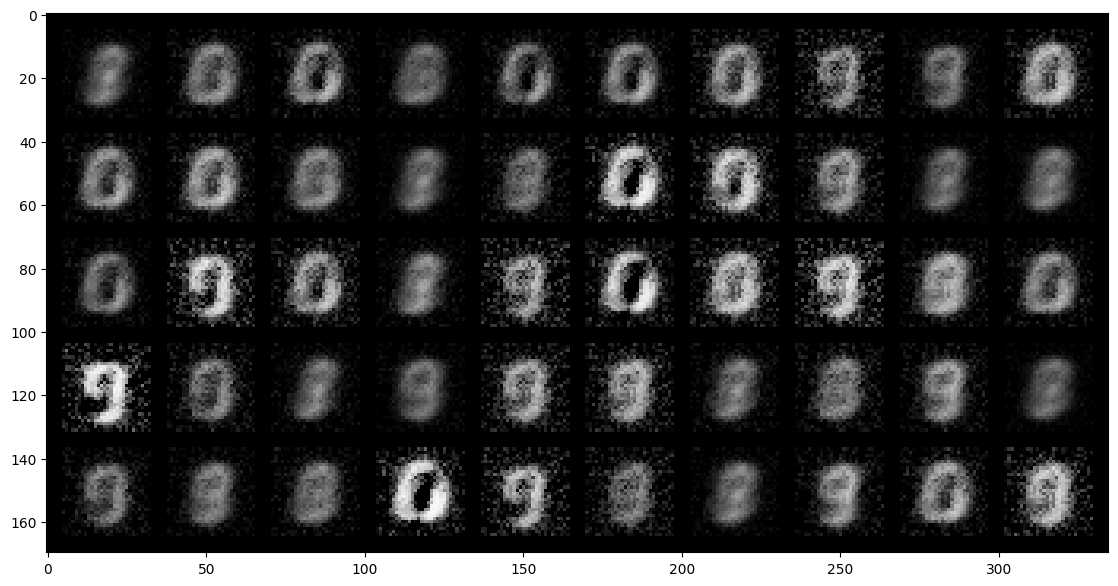

In [28]:
import torchvision

random_noise = torch.randn(128, input_size, device = device)

# generating fake image from random noise
fake = gen(random_noise)
fake = fake.cpu()

# plotting the fake image
fig, ax = plt.subplots(figsize = (15, 7))
show_image(torchvision.utils.make_grid(fake[0: 50], 10, 5))
plt.show()

---------------------------------------end of notebook---------------------------------------